## Reading and cleaning the df

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('/Users/katerynaburovova/PycharmProjects/dehumanization/annotation/dataset_v_1.csv')

In [29]:
import warnings
pd.options.mode.chained_assignment = None

In [12]:
import spacy
nlp = spacy.load('ru_core_news_md',disable=['ner', 'attribute_ruler'])

def lemmatize_spacy(text):
    doc = nlp(text)
    result = " ".join([token.lemma_ for token in doc])
    return result


In [13]:
cyrillic_letters = u"–∞–±–≤–≥–¥–µ—ë–∂–∑–∏–π–∫–ª–º–Ω–æ–ø—Ä—Å—Ç—É—Ñ—Ö—Ü—á—à—â—ä—ã—å—ç—é—è–ê–ë–í–ì–î–ï–Å–ñ–ó–ò–ô–ö–õ–ú–ù–û–ü–†–°–¢–£–§–•–¶–ß–®–©–™–´–¨–≠–Æ–Ø "

def clean_text(string, allowed_symbols):
    getVals = list(filter(lambda x: x in allowed_symbols, string))
    result = "".join(getVals)
    return result

In [14]:
def preprocess_df(df):
    df['text_clean'] = df['text'].apply(lambda x: clean_text(x.lower(), cyrillic_letters))
    df['text_lemmatized'] = df['text_clean'].apply(lambda x: lemmatize_spacy(x))
    df=df[df['text_clean']!='']
    df.reset_index(inplace=True)
    return df

In [15]:
%%time
df = preprocess_df(df)

NameError: name 'df' is not defined

## Embed

In [7]:
import torch
from transformers import AutoTokenizer, AutoModel

tokenizer_sent = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
model_sent = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

In [8]:
tokenizer_rukola = AutoTokenizer.from_pretrained("RussianNLP/ruRoBERTa-large-rucola")
model_rukola = AutoModel.from_pretrained("RussianNLP/ruRoBERTa-large-rucola")

In [10]:
tokenizer_rubert_tiny = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model_rubert_tiny = AutoModel.from_pretrained("cointegrated/rubert-tiny")

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
def embed_rubert(df, col='text_lemmatized', max_length=150, tokenizer = tokenizer_sent, model = model_sent):
    sent_list = df[col].to_list()
    encoded_input = tokenizer(sent_list, padding=True, max_length=max_length, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**encoded_input)
        vector_representations = model_output.last_hidden_state[:, 0, :]
    sent_array = vector_representations.numpy()
    print(f'The shape of resulting array is {sent_array.shape}')
    return vector_representations, sent_array

In [ ]:
%%time
vecs_rucola, sent_array_rucola = embed_rubert(df, col='text_clean', tokenizer=tokenizer_rukola, model=model_rukola)

In [ ]:
%%time
vecs_rubert, sent_array_rubert = embed_rubert(df)

In [68]:
%%time
vecs_tiny, sent_tiny = embed_rubert(df, col='text_clean', tokenizer=tokenizer_rubert_tiny, model=model_rubert_tiny)

The shape of resulting array is (3628, 312)
CPU times: user 34.1 s, sys: 33.9 s, total: 1min 8s
Wall time: 38 s


## Embed tfidf

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer

def embed_tf(df, col='text_lemmatized', max_df=0.99, min_df=0.01, ngram_range=(1,1)):
    tfidf_vec = TfidfVectorizer(max_df=max_df, min_df=min_df, ngram_range=ngram_range)
    sent_list = df[col].tolist()
    model = tfidf_vec.fit(sent_list)
    tdidf_array = model.transform(sent_list).toarray()
    return tdidf_array

In [20]:
tf_idf_array = embed_tf(df,  max_df=0.95, min_df=0.001, ngram_range=(1,3))

## HDBSCAN

In [13]:
import hdbscan
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [211]:
def create_hdbscan_clusters(min_cluster_size, array, alpha=1.0):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, alpha=alpha, cluster_selection_method='leaf').fit(array)
    clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette('deep', 8))
    # clusterer.condensed_tree_.plot()
    print(f'We got {clusterer.labels_.max()+2} labels')
    df_labels = pd.DataFrame(clusterer.labels_, columns = ['labels'])
    for label in range(-1, clusterer.labels_.max()+1):
        print(f'____________{label}')
        print(df['text_clean'][df_labels['labels']==label].sample(5))
    spread = [len(df_labels[df_labels['labels']==label]) for label in range(-1,clusterer.labels_.max()+1)]
    print(f'The distribution of labels is {spread}')
    return df_labels, clusterer.labels_, clusterer.probabilities_

# Experiments

We got 4 labels
____________-1
2758    —É –Ω–∏—Ö –≤—ã–±–æ—Ä —Ç–æ–ª—å–∫–æ –æ–¥–∏–Ω  —Å–¥–∞—Ç—å—Å—è –≤ –ø–ª–µ–Ω –∏–ª–∏ –æ—Ç...
2045    —è –ø—Ä–æ—Ç–∏–≤–Ω–∏–∫ –∑–∞–ø—Ä–µ—Ç–∞ –≤–µ–ª–∏–∫–∏—Ö –¥–µ–ª –ø–æ–∫–∞ –≤—Å–µ –º–∞–ª—ã–µ...
275     –º—ã –ø–æ—Å—Ç–æ—è–Ω–Ω–æ –≥–æ–≤–æ—Ä–∏–º –æ —Ñ–∞—à–∏—Å—Ç–∫–æ–π —Å–∏–º–≤–æ–ª–∏–∫–µ —Ö–æ—Ö...
3616    —É–∫—Ä–∞–∏–Ω—Å–∫–∏–µ —Ä–µ—Å—É—Ä—Å—ã –ø—É–±–ª–∏–∫—É—é—Ç –≤–∏–¥–µ–æ –∑–∞—Ö–æ–¥–∞ —É–∫—Ä–æ...
3395    –æ–∫–∞–∑—ã–≤–∞–µ—Ç—Å—è —Ö—É–¥–æ–∂–Ω–∏–∫ –∏ –ø—Ä–æ–¥—é—Å–µ—Ä —Ä–∞–π–¥–µ—Ä —Ä–∏–ø–ø—Å —É...
Name: text_clean, dtype: object
____________0
498          –º–∏–≥  —Ö–æ—Ö–ª–æ—Ä–µ–π—Ö–∞
2158      –¥–æ–±—Ä–æ–µ —É—Ç—Ä–æ –≤–∞—Ä—è–≥–∏
148     –Ω—é—Ö–µ–Ω—Ñ—é—Ä–µ—Ä —Å–∞–ª–æ—Ä–µ–π—Ö–∞
2600              –±–∞–Ω–¥–µ—Ä–æ–≤—Ü—ã
2063               —ç–∫—Å–∫–ª—é–∑–∏–≤
Name: text_clean, dtype: object
____________1
1102              –º–∏–Ω—É—Å –æ—á–µ—Ä–µ–¥–Ω–∞—è —Ä–∞—Å–ø–æ–ª–∞–≥–∞ —É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–≤ 
3158    –∫–æ–º–∞–Ω–¥–∏—Ä –ø–æ–¥—Ä–∞–∑–¥–µ–ª–µ–Ω–∏—è —É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–≤ —Ä—ã–¥–∞–

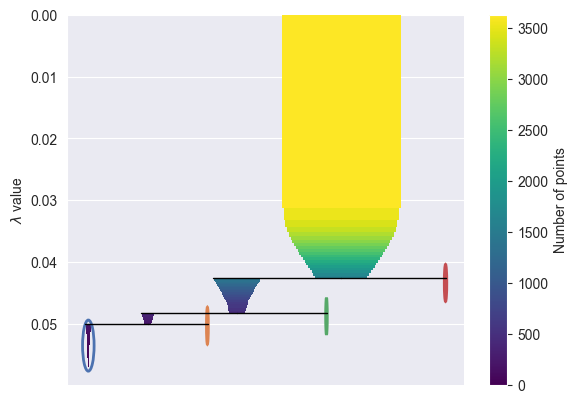

In [78]:
df_labels, hdbcan_labels, hdbcan_probabilities_ = create_hdbscan_clusters(20, sent_tiny, alpha=.2)

# –≤—ñ–¥—Ç–∏–Ω–∞—Ç–∏ —Ö–æ—Ö–ª–æ —ñ —É–∫—Ä–æ?

In [176]:
prefixes_list = ['—Ö–æ—Ö–ª–æ', '—É–∫—Ä–æ'] # list of prefixes to look for
# function to add space after prefix
def add_space(word, prefixes):
    for prefix in prefixes:
        if word.startswith(prefix):
            word = prefix + ' ' + word[len(prefix):]
    return word

def add_spaces_words(string, prefixes_list):
    result = ' '.join([add_space(word, prefixes=prefixes_list) for word in string.split(' ')])
    return result

In [177]:
add_spaces_words(df['text_lemmatized'][3], prefixes_list)

'—Ä–∞–Ω—å—à–µ —É–∫—Ä–æ –Ω–∞—Ü–∏—Å—Ç—ã —Å—Ç—Ä–æ–∏—Ç—å –ø–µ—Å—á–∞–Ω—ã–π –∑–∞–º–æ–∫   –Ω–æ —Ç–µ–ø–µ—Ä—å –ø–ª—è–∂ –∑–∞–º–∏–Ω–∏—Ä–æ–≤–∞—Ç—å'

In [179]:
df['text_lemmatized_separated'] = df['text_lemmatized'].apply(lambda x: add_spaces_words(x, prefixes_list))

In [180]:
df

text  \
0     –í–∞–≥–Ω–µ—Ä –æ—Ç–ø—Ä–∞–≤–ª—è–µ—Ç –∫ –±–∞–Ω–¥–µ—Ä–µ –∏ –ø—Ä–æ—á–∏–º —à–∞–π—Ç–∞–Ω–∞–º ...   
1     –¢—É—Ç –ø–æ–Ω–∏–º–∞–µ—à—å –≤—Å—ë –ø—Ä–æ –º–µ—Ç–∞—Ñ–∏–∑–∏–∫—É —ç—Ç–æ–π –≤–æ–π–Ω—ã. ¬´...   
2     –ù–∞—à –∏—Å—Ç–æ—á–Ω–∏–∫ —Å–æ–æ–±—â–∞–µ—Ç, —á—Ç–æ –æ—Å—Ç–∞—Ç–∫–∏ –≤–æ–µ–Ω–Ω–æ–π –∞–≤–∏...   
3     –†–∞–Ω—å—à–µ —É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—ã —Å—Ç—Ä–æ–∏–ª–∏ –ø–µ—Å—á–∞–Ω—ã–µ –∑–∞–º–∫–∏ ‚Äî –Ω–æ...   
4     –ò–º–µ–Ω–Ω–æ —ç—Ç–∏ —Ä–µ–≥–∏–æ–Ω—ã —è–≤–ª—è—é—Ç—Å—è –Ω–∞—Å—Ç–æ—è—â–∏–º —Ä–∞—Å—Å–∞–¥–Ω–∏...   
...                                                 ...   
3623     –°—Ç–æ–∏–º–æ—Å—Ç—å –æ—á–µ—Ä–µ–¥–Ω–æ–π –ø–æ–¥–∞—á–∫–∏ —Ö–æ—Ö–ª–∞–º - $675 –º–ª–Ω.   
3624  –•–æ—Ö–ª—è—á–∏–µ –∫–∞–Ω–∞–ª—ã —Å—Å—ã–ª–∞—è—Å—å –Ω–∞ –Ω–µ–∫—É—é —Ä–∞–∑–≤–µ–¥–∫—É —Å–æ–æ...   
3625  –û–±—Å—É–∂–¥–∞—é—Ç –Ω–µ–¥–æ—É–∫—Ä–∞–∏–Ω—Ü–∞ –ù–µ–≤–∑–æ—Ä–æ–≤–∞, –ê–Ω–Ω—É –ù–µ—Ç—Ä–µ–±–∫...   
3626  –ò –≤–æ—Ç –ø—Ä–∏—Ö–æ–¥–∏—Ç –∫–æ–ª–ª–µ–∫—Ç–∏–≤–Ω—ã–π –ó—É—Å—å–∫–æ –∏ –±—É–∫–≤–∞–ª—å–Ω–æ...   
3627  –ù—É, –≤–æ-–ø–µ—Ä–≤—ã—Ö —Å–ø–∞—Å–∏–±–æ –∑–∞ —É—Å—Ç–∞–Ω–æ–≤–æ—á–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ, ...   

                                             text_clean  \
0     –≤–∞–≥–Ω–µ—Ä –æ—Ç–ø—Ä–∞–≤–ª—è–µ—Ç –∫ –±–∞–Ω–¥–µ—Ä–µ –∏ –ø—Ä–æ—á–∏–º —à–∞–π—Ç–∞–Ω–∞–º ...   
1     —Ç—É—Ç –ø–æ–Ω–∏–º–∞–µ—à—å –≤—Å—ë –ø—Ä–æ –º–µ—Ç–∞—Ñ–∏–∑–∏–∫—É —ç—Ç–æ–π –≤–æ–π–Ω—ã —É–∫...   
2     –Ω–∞—à –∏—Å—Ç–æ—á–Ω–∏–∫ —Å–æ–æ–±—â–∞–µ—Ç —á—Ç–æ –æ—Å—Ç–∞—Ç–∫–∏ –≤–æ–µ–Ω–Ω–æ–π –∞–≤–∏–∞...   
3     —Ä–∞–Ω—å—à–µ —É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—ã —Å—Ç—Ä–æ–∏–ª–∏ –ø–µ—Å—á–∞–Ω—ã–µ –∑–∞–º–∫–∏  –Ω–æ ...   
4     –∏–º–µ–Ω–Ω–æ —ç—Ç–∏ —Ä–µ–≥–∏–æ–Ω—ã —è–≤–ª—è—é—Ç—Å—è –Ω–∞—Å—Ç–æ—è—â–∏–º —Ä–∞—Å—Å–∞–¥–Ω–∏...   
...                                                 ...   
3623           —Å—Ç–æ–∏–º–æ—Å—Ç—å –æ—á–µ—Ä–µ–¥–Ω–æ–π –ø–æ–¥–∞—á–∫–∏ —Ö–æ—Ö–ª–∞–º   –º–ª–Ω   
3624  —Ö–æ—Ö–ª—è—á–∏–µ –∫–∞–Ω–∞–ª—ã —Å—Å—ã–ª–∞—è—Å—å –Ω–∞ –Ω–µ–∫—É—é —Ä–∞–∑–≤–µ–¥–∫—É —Å–æ–æ...   
3625  –æ–±—Å—É–∂–¥–∞—é—Ç –Ω–µ–¥–æ—É–∫—Ä–∞–∏–Ω—Ü–∞ –Ω–µ–≤–∑–æ—Ä–æ–≤–∞ –∞–Ω–Ω—É –Ω–µ—Ç—Ä–µ–±–∫–æ...   
3626  –∏ –≤–æ—Ç –ø—Ä–∏—Ö–æ–¥–∏—Ç –∫–æ–ª–ª–µ–∫—Ç–∏–≤–Ω—ã–π –∑—É—Å—å–∫–æ –∏ –±—É–∫–≤–∞–ª—å–Ω–æ...   
3627  –Ω—É –≤–æ–ø–µ—Ä–≤—ã—Ö —Å–ø–∞—Å–∏–±–æ –∑–∞ —É—Å—Ç–∞–Ω–æ–≤–æ—á–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ –∞ –≤...   

                                        text_lemmatized  \
0     –≤–∞–≥–Ω–µ—Ä –æ—Ç–ø—Ä–∞–≤–ª—è—Ç—å –∫ –±–∞–Ω–¥–µ—Ä–µ –∏ –ø—Ä–æ—á–∏–º —à–∞–π—Ç–∞–Ω –≤ ...   
1     —Ç—É—Ç –ø–æ–Ω–∏–º–∞—Ç—å –≤—Å—ë –ø—Ä–æ –º–µ—Ç–∞—Ñ–∏–∑–∏–∫–∞ —ç—Ç–æ—Ç –≤–æ–π–Ω–∞ —É–∫—Ä...   
2     –Ω–∞—à –∏—Å—Ç–æ—á–Ω–∏–∫ —Å–æ–æ–±—â–∞—Ç—å —á—Ç–æ –æ—Å—Ç–∞—Ç–æ–∫ –≤–æ–µ–Ω–Ω—ã–π –∞–≤–∏–∞...   
3     —Ä–∞–Ω—å—à–µ —É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—ã —Å—Ç—Ä–æ–∏—Ç—å –ø–µ—Å—á–∞–Ω—ã–π –∑–∞–º–æ–∫   –Ω–æ...   
4     –∏–º–µ–Ω–Ω–æ —ç—Ç–æ—Ç —Ä–µ–≥–∏–æ–Ω —è–≤–ª—è—Ç—å—Å—è –Ω–∞—Å—Ç–æ—è—â–∏–π —Ä–∞—Å—Å–∞–¥–Ω–∏...   
...                                                 ...   
3623           —Å—Ç–æ–∏–º–æ—Å—Ç—å –æ—á–µ—Ä–µ–¥–Ω–æ–π –ø–æ–¥–∞—á–∫–∞ —Ö–æ—Ö–æ–ª    –º–ª–Ω   
3624  —Ö–æ—Ö–ª—è—á–∏–µ –∫–∞–Ω–∞–ª —Å—Å—ã–ª–∞—Ç—å—Å—è –Ω–∞ –Ω–µ–∫–∏–π —Ä–∞–∑–≤–µ–¥–∫–∞ —Å–æ–æ...   
3625  –æ–±—Å—É–∂–¥–∞—Ç—å –Ω–µ–¥–æ—É–∫—Ä–∞–∏–Ω—Ü–∞ –Ω–µ–≤–∑–æ—Ä–æ–≤ –∞–Ω–Ω–∞ –Ω–µ—Ç—Ä–µ–±–∫–æ ...   
3626  –∏ –≤–æ—Ç –ø—Ä–∏—Ö–æ–¥–∏—Ç—å –∫–æ–ª–ª–µ–∫—Ç–∏–≤–Ω—ã–π –∑—É—Å—å–∫–æ –∏ –±—É–∫–≤–∞–ª—å–Ω...   
3627  –Ω—É –≤–æ–ø–µ—Ä–≤—ã—Ö —Å–ø–∞—Å–∏–±–æ –∑–∞ —É—Å—Ç–∞–Ω–æ–≤–æ—á–Ω—ã–π –¥–∞–Ω–Ω—ã–µ –∞ –≤...   

                              text_lemmatized_separated  
0     –≤–∞–≥–Ω–µ—Ä –æ—Ç–ø—Ä–∞–≤–ª—è—Ç—å –∫ –±–∞–Ω–¥–µ—Ä–µ –∏ –ø—Ä–æ—á–∏–º —à–∞–π—Ç–∞–Ω –≤ ...  
1     —Ç—É—Ç –ø–æ–Ω–∏–º–∞—Ç—å –≤—Å—ë –ø—Ä–æ –º–µ—Ç–∞—Ñ–∏–∑–∏–∫–∞ —ç—Ç–æ—Ç –≤–æ–π–Ω–∞ —É–∫—Ä...  
2     –Ω–∞—à –∏—Å—Ç–æ—á–Ω–∏–∫ —Å–æ–æ–±—â–∞—Ç—å —á—Ç–æ –æ—Å—Ç–∞—Ç–æ–∫ –≤–æ–µ–Ω–Ω—ã–π –∞–≤–∏–∞...  
3     —Ä–∞–Ω—å—à–µ —É–∫—Ä–æ –Ω–∞—Ü–∏—Å—Ç—ã —Å—Ç—Ä–æ–∏—Ç—å –ø–µ—Å—á–∞–Ω—ã–π –∑–∞–º–æ–∫   –Ω...  
4     –∏–º–µ–Ω–Ω–æ —ç—Ç–æ—Ç —Ä–µ–≥–∏–æ–Ω —è–≤–ª—è—Ç—å—Å—è –Ω–∞—Å—Ç–æ—è—â–∏–π —Ä–∞—Å—Å–∞–¥–Ω–∏...  
...                                                 ...  
3623           —Å—Ç–æ–∏–º–æ—Å—Ç—å –æ—á–µ—Ä–µ–¥–Ω–æ–π –ø–æ–¥–∞—á–∫–∞ —Ö–æ—Ö–æ–ª    –º–ª–Ω  
3624  —Ö–æ—Ö–ª—è—á–∏–µ –∫–∞–Ω–∞–ª —Å—Å—ã–ª–∞—Ç—å—Å—è –Ω–∞ 

In [189]:
%%time
tf_idf_array = embed_tf(df, col='text_lemmatized_separated', max_df=0.3, min_df=0.01, ngram_range=(1,5))

CPU times: user 305 ms, sys: 25.4 ms, total: 330 ms
Wall time: 337 ms


We got 7 labels
____________-1
1236    –ø—Ä–∏–∑–Ω–∞–Ω–∏–µ –æ–¥–Ω–æ–≥–æ –∏–∑ —Å–∞–º—ã—Ö –æ–¥–∏–æ–∑–Ω—ã—Ö –¥–µ—è—Ç–µ–ª–µ–π —Å–∞...
2469    —ç–∫—Å–¥–µ–ø—É—Ç–∞—Ç –≥–¥ –æ—Ç –ª–¥–ø—Ä –º–≥–ª—É—â–µ–Ω–∫–æ –æ–Ω –∂–µ –ø—Ä–µ—Å—Ç—É–ø–Ω...
626     –æ—á–µ—Ä–µ–¥–Ω–æ–µ –≤–∏–¥–µ–æ –æ—Ç —Ö–æ—Ö–ª–æ–ø–µ—Ç—É—Ö–æ–≤ –≥–¥–µ –æ–Ω–∏ —Å –±–ø–ª–∞...
3309    –≤–∏–Ω—Ç–æ–≤–∫–∞ –ø—Ä–æ–¥–æ–ª–∂–∏—Ç –æ—Ç–ø—Ä–∞–≤–ª—è—Ç—å –∫ –±–∞–Ω–¥–µ—Ä–µ —É–∫—Ä–∞–∏–Ω...
2654    –≤–Ω–∏–º–∞–Ω–∏–µ –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—è —Ç–æ–ª—å–∫–æ –¥–ª—è –æ–¥–µ—Å—Å–∫–∏—Ö —É–∫—Ä–æ–ø–∞...
Name: text_clean, dtype: object
____________0
148                                  –Ω—é—Ö–µ–Ω—Ñ—é—Ä–µ—Ä —Å–∞–ª–æ—Ä–µ–π—Ö–∞
2006                                               –ø–æ–º–Ω–∏–º
132                           –æ–±–Ω—É–ª–µ–Ω–∏–µ –ø–æ–¥–∫—Ä–µ–ø–ª–µ–Ω–∏—è –≤—Å—É–∫
1624                                               –º–æ—â–Ω–æ 
1758    –∫–ª—é—á–µ–≤–∞—è –æ–ø–∞—Å–Ω–æ—Å—Ç—å –≤ –ø–µ—Ä–º–∏ –¥–ª—è –≤–∞—Ä—è–≥–∞ –º–∏—Ö–∞–∏–ª–∞ ...
Name: text_clean, dtype: object
____________1
800

/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/hdbscan/plots.py:383: UserWarning: Infinite lambda values encountered in chosen clusters. This might be due to duplicates in the data.
  warn('Infinite lambda values encountered in chosen clusters.'


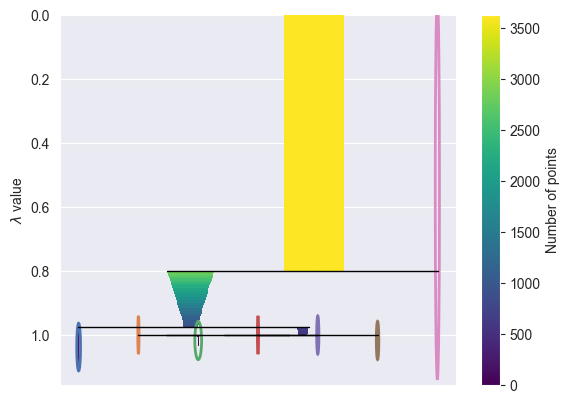

In [191]:
df_labels, tf2_dbcan_labels, tf2_hdbcan_probabilities_ = create_hdbscan_clusters(30, tf_idf_array, 0.8)

In [192]:
import fasttext

model_path = '/Users/katerynaburovova/PycharmProjects/dehumanization/fasttext_models/cc.ru.300.bin'
ftt_model = fasttext.load_model(model_path)

In [193]:
embedding_word = ftt_model.get_word_vector('–ø—Ä–∏–≤–µ—Ç')
sentence = '–≠—Ç–æ —Ç–µ—Å—Ç–æ–≤–æ–µ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–µ –¥–ª—è –ø–æ–ª—É—á–µ–Ω–∏—è –≤–µ–∫—Ç–æ—Ä–Ω–æ–≥–æ –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–∏—è'
embedding_sent = ftt_model.get_sentence_vector(sentence)

In [194]:
embedding_word.shape, embedding_sent.shape

((300,), (300,))

In [229]:
df['ftt_emb'] = df['text_clean'].apply(lambda x: ftt_model.get_sentence_vector(x))

In [230]:
ftt_array = df['ftt_emb'].apply(pd.Series)

We got 6 labels
____________-1
384     —Å–ø–µ—Ü–Ω–∞–∑ —Ñ—Å–± —Å–æ–≤–º–µ—Å—Ç–Ω–æ —Å –ø–æ–ª–∏—Ü–µ–π—Å–∫–∏–º–∏ –∑–∞–¥–µ—Ä–∂–∞–ª ...
2539                   —Ç–µ–ø–µ—Ä—å –∏ —Å–∞–º —á—É–±–∞–π—Å –ø–æ–∫–∏–Ω—É–ª —Å—Ç—Ä–∞–Ω—É
298     —Ç–æ—Ç —Å–ª—É—á–∞–π –∫–æ–≥–¥–∞ —É–∫—Ä–æ–∑–æ–ª—å–¥–∞—Ç—ç–Ω —Ä–∞–∑–º–∞—Ä–∞–¥—ë—Ä–∏–ª–∏ –∂...
2580    —Ñ—Å–± –∑–∞–¥–µ—Ä–∂–∞–ª–∞ –≤ —Ä–æ—Å—Ç–æ–≤—Å–∫–æ–π –æ–±–ª–∞—Å—Ç–∏ —Å—Ç–æ—Ä–æ–Ω–Ω–∏–∫–∞ ...
1678                         –Ω–∞—Ä–æ–¥—É –Ω–µ–º–Ω–æ–≥–æ –∞ –¥–µ–ª–æ –≤–∞–∂–Ω–æ–µ
Name: text_clean, dtype: object
____________0
861     –≤—Å–µ–º —É—Ç—Ä–µ–Ω–Ω–∏–π —Å–∞–ª–∞–º  –≤—Å–µ–º –∫—Ä–æ–º–µ –Ω–∞—Ü–∏—Å—Ç–æ–≤ —É–∫—Ä–æ—Ä...
872                    –≤—Å–µ–º —Å–∞–ª–∞–º  –≤—Å–µ–º –∫—Ä–æ–º–µ —É–∫—Ä–æ–ø–∏—Ç–µ–∫–æ–≤
3232                        –≤—Å–µ–º —Å–∞–ª–∞–º  –≤—Å–µ–º –∫—Ä–æ–º–µ —Ö–æ—Ö–ª–æ–≤
815     –≤—Å–µ–º —á–∏—Ç–∞—Ç–µ–ª—è–º –∫–∞–Ω–∞–ª–∞  —É—Ç—Ä–µ–Ω–Ω–∏–π —Å–∞–ª–∞–º  –≤—Å–µ–º –∫—Ä...
157            –≤—Å–µ–º —É—Ç—Ä–µ–Ω–Ω–∏–π —Å–∞–ª–∞–º  –≤—Å–µ–º –∫—Ä–æ–º–µ —á—É–±–∞–Ω–æ–∏–¥–æ–≤
Nam

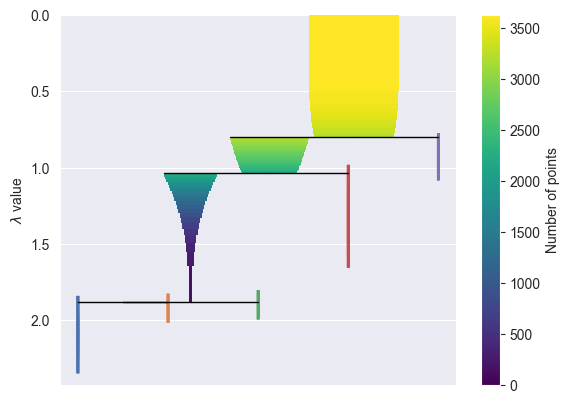

In [231]:
%%time
ftt_df_labels, ftt_hdbcan_labels, ftt_hdbcan_probabilities_ = create_hdbscan_clusters(5, ftt_array, alpha=.3)

In [238]:
df[ftt_df_labels['labels']==4]['text_clean'].iloc[1]

'–Ω–∞–ø—Ä–∏–º–µ—Ä –æ–±–µ—â–∞—Ç—å –ø–µ—Ä–µ–±–∏—Ç—å  –ø—Ä–æ—Ü–µ–Ω—Ç–æ–≤ –∑–µ–º–ª—è–∫–æ–≤ –∫–∞–∫ –Ω–∞ –∫–∞—Ä—Ç–∏–Ω–∫–µ –∏–ª–∏ –≤—ã–ª–æ–∂–∏—Ç—å —Ç—Ä—É–ø—ã –≤ –º–µ—à–∫–∞—Ö –ø–µ—Ä–µ–¥ —Å–∞—Ö–∏–±–∞–º–∏ —Å –µ—Å –∫–∞–∫ –≤—á–µ—Ä–∞ —Å–æ—Ç—Ä—É–¥–Ω–∏–∫–∏ –∫–æ—Ä–ø–æ—Ä–∞—Ü–∏–∏ –∑–µ–ª–µ–Ω—Å–∫–∏–π –∏ –∫–æ—á—Ç–æ –∏–Ω—Ç–µ—Ä–µ—Å–Ω–æ —Ç—Ä—É–ø—ã –Ω–µ–¥–µ–ª—é –Ω–µ –∏–∑—É—á–∞—é—Ç –∏ –Ω–µ –∑–∞—Ö–æ—Ä–∞–Ω–∏–≤–∞—é—Ç —É–∫—Ä–∞–∏–Ω–µ—Ü –∏ –ø–æ—Å–ª–µ —Å–º–µ—Ä—Ç–∏ –¥–æ–ª–∂–µ–Ω —Å–ª—É–∂–∏—Ç—å —Å–≤–∏–Ω–æ—Ä–µ–π—Ö—É –¥–∞–∂–µ –µ—Å–ª–∏ –µ–≥–æ —É–±–∏–ª –∏–º–µ–Ω–Ω–æ —Å–≤–∏–Ω–æ—Ä–µ–π—Ö —Å–≤–∞–ª–∏—Ç—å –≤ –∏–∑—Ä–∞–∏–ª—å –∏ –≤—Å–ø–æ–º–Ω–∏—Ç—å –±–∞–±—É—à–∫—É–µ–≤—Ä–µ–π–∫—É —Å –ø–æ—Ä—Ç—É–≥–∞–ª—å—Å–∫–∏–º–∏ –∫–æ—Ä–Ω—è–º–∏ –∞ –ø–æ—Ç–æ–º –æ—Ç—Ç—É–¥–∞ –Ω—ã—Ç—å —á—Ç–æ —Ç—ã –∏ –µ—Å—Ç—å —Ä–æ—Å—Å–∏—è'

## Kmeans

In [4]:
import pandas as pd
df_collocations = pd.read_csv('/Users/katerynaburovova/PycharmProjects/dehumanization/annotation/dataset_v_collocations.csv', index_col=0)

In [8]:
# %%time
# import ast
# df_collocations['core_noun_verb'] = df_collocations['core_noun_verb'].apply(ast.literal_eval)

In [9]:
df_collocations = df_collocations[['text', 'core_noun_verb_str', 'verb_obl_obj_str', 'appos_str', 'amod_str', 'nmod_str']]

In [10]:
df_collocations

text  \
0     –í–∞–≥–Ω–µ—Ä –æ—Ç–ø—Ä–∞–≤–ª—è–µ—Ç –∫ –±–∞–Ω–¥–µ—Ä–µ –∏ –ø—Ä–æ—á–∏–º —à–∞–π—Ç–∞–Ω–∞–º ...   
1     –¢—É—Ç –ø–æ–Ω–∏–º–∞–µ—à—å –≤—Å—ë –ø—Ä–æ –º–µ—Ç–∞—Ñ–∏–∑–∏–∫—É —ç—Ç–æ–π –≤–æ–π–Ω—ã. ¬´...   
2     –ù–∞—à –∏—Å—Ç–æ—á–Ω–∏–∫ —Å–æ–æ–±—â–∞–µ—Ç, —á—Ç–æ –æ—Å—Ç–∞—Ç–∫–∏ –≤–æ–µ–Ω–Ω–æ–π –∞–≤–∏...   
3     –†–∞–Ω—å—à–µ —É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—ã —Å—Ç—Ä–æ–∏–ª–∏ –ø–µ—Å—á–∞–Ω—ã–µ –∑–∞–º–∫–∏ ‚Äî –Ω–æ...   
4     –ò–º–µ–Ω–Ω–æ —ç—Ç–∏ —Ä–µ–≥–∏–æ–Ω—ã —è–≤–ª—è—é—Ç—Å—è –Ω–∞—Å—Ç–æ—è—â–∏–º —Ä–∞—Å—Å–∞–¥–Ω–∏...   
...                                                 ...   
3638     –°—Ç–æ–∏–º–æ—Å—Ç—å –æ—á–µ—Ä–µ–¥–Ω–æ–π –ø–æ–¥–∞—á–∫–∏ —Ö–æ—Ö–ª–∞–º - $675 –º–ª–Ω.   
3639  –•–æ—Ö–ª—è—á–∏–µ –∫–∞–Ω–∞–ª—ã —Å—Å—ã–ª–∞—è—Å—å –Ω–∞ –Ω–µ–∫—É—é —Ä–∞–∑–≤–µ–¥–∫—É —Å–æ–æ...   
3640  –û–±—Å—É–∂–¥–∞—é—Ç –Ω–µ–¥–æ—É–∫—Ä–∞–∏–Ω—Ü–∞ –ù–µ–≤–∑–æ—Ä–æ–≤–∞, –ê–Ω–Ω—É –ù–µ—Ç—Ä–µ–±–∫...   
3641  –ò –≤–æ—Ç –ø—Ä–∏—Ö–æ–¥–∏—Ç –∫–æ–ª–ª–µ–∫—Ç–∏–≤–Ω—ã–π –ó—É—Å—å–∫–æ –∏ –±—É–∫–≤–∞–ª—å–Ω–æ...   
3642  –ù—É, –≤–æ-–ø–µ—Ä–≤—ã—Ö —Å–ø–∞—Å–∏–±–æ –∑–∞ —É—Å—Ç–∞–Ω–æ–≤–æ—á–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ, ...   

                                     core_noun_verb_str  \
0                                     –≤–∞–≥–Ω–µ—Ä –æ—Ç–ø—Ä–∞–≤–ª—è–µ—Ç   
1                               —É–∫—Ä–æ–ø—ã –≤—ã—à–ª–∏, –æ–Ω–∏ –≤—ã—à–ª–∏   
2                         –∏—Å—Ç–æ—á–Ω–∏–∫ —Å–æ–æ–±—â–∞–µ—Ç –ø–µ—Ä–µ–±—Ä–æ—à–µ–Ω–∞   
3     —É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—ã —Ä–∞–Ω—å—à–µ —Å—Ç—Ä–æ–∏–ª–∏, —É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—ã —Ç–µ–ø–µ—Ä—å...   
4           —Ä–µ–≥–∏–æ–Ω—ã —è–≤–ª—è—é—Ç—Å—è —Ä–∞—Å—Å–∞–¥–Ω–∏–∫–æ–º, —Ä–µ–≥–∏–æ–Ω—ã –∏–º–µ—é—Ç   
...                                                 ...   
3638                                                NaN   
3639  –∫–∞–Ω–∞–ª—ã —Å–æ–æ–±—â–∞—é—Ç, –≤—Å –≥–æ—Ç–æ–≤—ã –ø–æ–¥–æ—Ä–≤–∞—Ç—å, –∑–µ–ª–µ–Ω—Å–∫–∏...   
3640                                                NaN   
3641  –∑—É—Å—å–∫–æ –≤–æ—Ç –ø—Ä–∏—Ö–æ–¥–∏—Ç, –∑—É—Å—å–∫–æ –±—É–∫–≤–∞–ª—å–Ω–æ –Ω–∞—á–∏–Ω–∞–µ—Ç...   
3642                          —Ö–ª–æ–ø—Ü—ã –±–∏–∑–Ω–µ—Å, —ç—Ç–æ –±–∏–∑–Ω–µ—Å   

                                       verb_obl_obj_str  \
0              –æ—Ç–ø—Ä–∞–≤–ª—è–µ—Ç –∫ –±–∞–Ω–¥–µ—Ä–µ, –æ—Ç–ø—Ä–∞–≤–ª—è–µ—Ç –±—Ä–∏–≥–∞–¥—ã   
1     —Ç—É—Ç –ø–æ–Ω–∏–º–∞–µ—à—å –≤—Å—ë, —Ç—É—Ç –ø–æ–Ω–∏–º–∞–µ—à—å –ø—Ä–æ –º–µ—Ç–∞—Ñ–∏–∑–∏–∫...   
2                               –ø–µ—Ä–µ–±—Ä–æ—à–µ–Ω–∞ –Ω–∞ –∞—ç—Ä–æ–¥—Ä–æ–º   
3                                  —Ä–∞–Ω—å—à–µ —Å—Ç—Ä–æ–∏–ª–∏ –∑–∞–º–∫–∏   
4                    –∏–º–µ—é—Ç –¥–ª—è —É–∫—Ä–æ–Ω–∞—Ü–∏–∫–æ–≤, –∏–º–µ—é—Ç —Å–º—ã—Å–ª   
...                                                 ...   
3638                                                NaN   
3639  —Å—Å—ã–ª–∞—è—Å—å –Ω–∞ —Ä–∞–∑–≤–µ–¥–∫—É, —Å–æ–æ–±—â–∞—é—Ç –æ —Ç–æ–º, –ø–æ–¥–æ—Ä–≤–∞—Ç...   
3640                             –æ–±—Å—É–∂–¥–∞—é—Ç –Ω–µ–¥–æ—É–∫—Ä–∞–∏–Ω—Ü–∞   
3641  –±—É–∫–≤–∞–ª—å–Ω–æ –Ω–∞—á–∏–Ω–∞–µ—Ç —Ö–æ—Ö–ª–æ–≤ –∑–∞–≤–∞–ª–∏–≤–∞—Ç—å, –∑–∞–≤–∞–ª–∏–≤–∞...   
3642                                                NaN   

                     appos_str  \
0     –±–∞—Ç–∞–ª—å–æ–Ω –¥–∂–æ—Ö–∞—Ä–∞ –¥—É–¥–∞–µ–≤–∞   
1                          NaN   
2                 –∞—ç—Ä–æ–¥—Ä–æ–º —Ä–æ–≥   
3                          NaN   
4                          NaN   
...                        ...   
3638                       NaN   
3639                       NaN   
3640                       NaN   
3641                       NaN   
3642                       NaN   

                                               amod_str  \
0     –ø—Ä–æ—á–∏–º —à–∞–π—Ç–∞–Ω–∞–º, —Å–ª–µ–¥—É—é—â–∏–µ –±—Ä–∏–≥–∞–¥—ã, —à–∞–π—Ç–∞–Ω—Å–∫–∏–π...   
1                                                   NaN   
2                –≤–æ–µ–Ω–Ω–æ–π –∞–≤–∏–∞—Ü–∏–∏, –¥–æ–ª–≥–∏–Ω—Ü–µ–≤–æ(–∫—Ä–∏–≤–æ–π —Ä–æ–≥   
3                                        –ø–µ—Å—á–∞–Ω—ã–µ –∑–∞–º–∫–∏   
4     –Ω–∞—Å—Ç–æ—è—â–∏–º —Ä–∞—Å—Å–∞–¥–Ω–∏–∫–æ–º, —Å–∞–∫—Ä–∞–ª—å–Ω—ã–π —Å–º—ã—Å–ª, –∏–¥–µ–æ–ª...   
...                                                 ...   
3638                           –æ—á–µ—Ä–µ–¥–Ω–æ–π –ø–æ–¥–∞—á–∫–∏, - –º

In [16]:
%%time
df_collocations = preprocess_df(df_collocations)

/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_89492/3268668609.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_clean'] = df['text'].apply(lambda x: clean_text(x.lower(), cyrillic_letters))


CPU times: user 18.9 s, sys: 129 ms, total: 19 s
Wall time: 19 s


/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_89492/3268668609.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_lemmatized'] = df['text_clean'].apply(lambda x: lemmatize_spacy(x))


In [18]:
df_collocations.drop(columns=['index'], inplace=True)

/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_89492/4110097691.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_collocations.drop(columns=['index'], inplace=True)


In [19]:
df_collocations

text  \
0     –í–∞–≥–Ω–µ—Ä –æ—Ç–ø—Ä–∞–≤–ª—è–µ—Ç –∫ –±–∞–Ω–¥–µ—Ä–µ –∏ –ø—Ä–æ—á–∏–º —à–∞–π—Ç–∞–Ω–∞–º ...   
1     –¢—É—Ç –ø–æ–Ω–∏–º–∞–µ—à—å –≤—Å—ë –ø—Ä–æ –º–µ—Ç–∞—Ñ–∏–∑–∏–∫—É —ç—Ç–æ–π –≤–æ–π–Ω—ã. ¬´...   
2     –ù–∞—à –∏—Å—Ç–æ—á–Ω–∏–∫ —Å–æ–æ–±—â–∞–µ—Ç, —á—Ç–æ –æ—Å—Ç–∞—Ç–∫–∏ –≤–æ–µ–Ω–Ω–æ–π –∞–≤–∏...   
3     –†–∞–Ω—å—à–µ —É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—ã —Å—Ç—Ä–æ–∏–ª–∏ –ø–µ—Å—á–∞–Ω—ã–µ –∑–∞–º–∫–∏ ‚Äî –Ω–æ...   
4     –ò–º–µ–Ω–Ω–æ —ç—Ç–∏ —Ä–µ–≥–∏–æ–Ω—ã —è–≤–ª—è—é—Ç—Å—è –Ω–∞—Å—Ç–æ—è—â–∏–º —Ä–∞—Å—Å–∞–¥–Ω–∏...   
...                                                 ...   
3623     –°—Ç–æ–∏–º–æ—Å—Ç—å –æ—á–µ—Ä–µ–¥–Ω–æ–π –ø–æ–¥–∞—á–∫–∏ —Ö–æ—Ö–ª–∞–º - $675 –º–ª–Ω.   
3624  –•–æ—Ö–ª—è—á–∏–µ –∫–∞–Ω–∞–ª—ã —Å—Å—ã–ª–∞—è—Å—å –Ω–∞ –Ω–µ–∫—É—é —Ä–∞–∑–≤–µ–¥–∫—É —Å–æ–æ...   
3625  –û–±—Å—É–∂–¥–∞—é—Ç –Ω–µ–¥–æ—É–∫—Ä–∞–∏–Ω—Ü–∞ –ù–µ–≤–∑–æ—Ä–æ–≤–∞, –ê–Ω–Ω—É –ù–µ—Ç—Ä–µ–±–∫...   
3626  –ò –≤–æ—Ç –ø—Ä–∏—Ö–æ–¥–∏—Ç –∫–æ–ª–ª–µ–∫—Ç–∏–≤–Ω—ã–π –ó—É—Å—å–∫–æ –∏ –±—É–∫–≤–∞–ª—å–Ω–æ...   
3627  –ù—É, –≤–æ-–ø–µ—Ä–≤—ã—Ö —Å–ø–∞—Å–∏–±–æ –∑–∞ —É—Å—Ç–∞–Ω–æ–≤–æ—á–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ, ...   

                                     core_noun_verb_str  \
0                                     –≤–∞–≥–Ω–µ—Ä –æ—Ç–ø—Ä–∞–≤–ª—è–µ—Ç   
1                               —É–∫—Ä–æ–ø—ã –≤—ã—à–ª–∏, –æ–Ω–∏ –≤—ã—à–ª–∏   
2                         –∏—Å—Ç–æ—á–Ω–∏–∫ —Å–æ–æ–±—â–∞–µ—Ç –ø–µ—Ä–µ–±—Ä–æ—à–µ–Ω–∞   
3     —É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—ã —Ä–∞–Ω—å—à–µ —Å—Ç—Ä–æ–∏–ª–∏, —É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—ã —Ç–µ–ø–µ—Ä—å...   
4           —Ä–µ–≥–∏–æ–Ω—ã —è–≤–ª—è—é—Ç—Å—è —Ä–∞—Å—Å–∞–¥–Ω–∏–∫–æ–º, —Ä–µ–≥–∏–æ–Ω—ã –∏–º–µ—é—Ç   
...                                                 ...   
3623                                                NaN   
3624  –∫–∞–Ω–∞–ª—ã —Å–æ–æ–±—â–∞—é—Ç, –≤—Å –≥–æ—Ç–æ–≤—ã –ø–æ–¥–æ—Ä–≤–∞—Ç—å, –∑–µ–ª–µ–Ω—Å–∫–∏...   
3625                                                NaN   
3626  –∑—É—Å—å–∫–æ –≤–æ—Ç –ø—Ä–∏—Ö–æ–¥–∏—Ç, –∑—É—Å—å–∫–æ –±—É–∫–≤–∞–ª—å–Ω–æ –Ω–∞—á–∏–Ω–∞–µ—Ç...   
3627                          —Ö–ª–æ–ø—Ü—ã –±–∏–∑–Ω–µ—Å, —ç—Ç–æ –±–∏–∑–Ω–µ—Å   

                                       verb_obl_obj_str  \
0              –æ—Ç–ø—Ä–∞–≤–ª—è–µ—Ç –∫ –±–∞–Ω–¥–µ—Ä–µ, –æ—Ç–ø—Ä–∞–≤–ª—è–µ—Ç –±—Ä–∏–≥–∞–¥—ã   
1     —Ç—É—Ç –ø–æ–Ω–∏–º–∞–µ—à—å –≤—Å—ë, —Ç—É—Ç –ø–æ–Ω–∏–º–∞–µ—à—å –ø—Ä–æ –º–µ—Ç–∞—Ñ–∏–∑–∏–∫...   
2                               –ø–µ—Ä–µ–±—Ä–æ—à–µ–Ω–∞ –Ω–∞ –∞—ç—Ä–æ–¥—Ä–æ–º   
3                                  —Ä–∞–Ω—å—à–µ —Å—Ç—Ä–æ–∏–ª–∏ –∑–∞–º–∫–∏   
4                    –∏–º–µ—é—Ç –¥–ª—è —É–∫—Ä–æ–Ω–∞—Ü–∏–∫–æ–≤, –∏–º–µ—é—Ç —Å–º—ã—Å–ª   
...                                                 ...   
3623                                                NaN   
3624  —Å—Å—ã–ª–∞—è—Å—å –Ω–∞ —Ä–∞–∑–≤–µ–¥–∫—É, —Å–æ–æ–±—â–∞—é—Ç –æ —Ç–æ–º, –ø–æ–¥–æ—Ä–≤–∞—Ç...   
3625                             –æ–±—Å—É–∂–¥–∞—é—Ç –Ω–µ–¥–æ—É–∫—Ä–∞–∏–Ω—Ü–∞   
3626  –±—É–∫–≤–∞–ª—å–Ω–æ –Ω–∞—á–∏–Ω–∞–µ—Ç —Ö–æ—Ö–ª–æ–≤ –∑–∞–≤–∞–ª–∏–≤–∞—Ç—å, –∑–∞–≤–∞–ª–∏–≤–∞...   
3627                                                NaN   

                     appos_str  \
0     –±–∞—Ç–∞–ª—å–æ–Ω –¥–∂–æ—Ö–∞—Ä–∞ –¥—É–¥–∞–µ–≤–∞   
1                          NaN   
2                 –∞—ç—Ä–æ–¥—Ä–æ–º —Ä–æ–≥   
3                          NaN   
4                          NaN   
...                        ...   
3623                       NaN   
3624                       NaN   
3625                       NaN   
3626                       NaN   
3627                       NaN   

                                               amod_str  \
0     –ø—Ä–æ—á–∏–º —à–∞–π—Ç–∞–Ω–∞–º, —Å–ª–µ–¥—É—é—â–∏–µ –±—Ä–∏–≥–∞–¥—ã, —à–∞–π—Ç–∞–Ω—Å–∫–∏–π...   
1                                                   NaN   
2                –≤–æ–µ–Ω–Ω–æ–π –∞–≤–∏–∞—Ü–∏–∏, –¥–æ–ª–≥–∏–Ω—Ü–µ–≤–æ(–∫—Ä–∏–≤–æ–π —Ä–æ–≥   
3                                        –ø–µ—Å—á–∞–Ω—ã–µ –∑–∞–º–∫–∏   
4     –Ω–∞—Å—Ç–æ—è—â–∏–º —Ä–∞—Å—Å–∞–¥–Ω–∏–∫–æ–º, —Å–∞–∫—Ä–∞–ª—å–Ω—ã–π —Å–º—ã—Å–ª, –∏–¥–µ–æ–ª...   
...                                                 ...   
3623                           –æ—á–µ—Ä–µ–¥–Ω–æ–π –ø–æ–¥–∞—á–∫–∏, - –º

In [81]:
def cluster_with_kmeans(df, num_clusters, col_list):
    pd.set_option('display.max_colwidth', None)
    columns_to_cluster = col_list
    text_data = df[columns_to_cluster].apply(lambda x: ' '.join(x.astype(str)), axis=1)
    tfidf_vectorizer = TfidfVectorizer()
    X = tfidf_vectorizer.fit_transform(text_data)
    n_clusters = num_clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    timestamp_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    cluster_labels_name = f'cluster_{n_clusters}_{"_".join(columns_to_cluster)}_{timestamp_str}'
    df[cluster_labels_name] = kmeans.labels_

    # Print the resulting clusters
    for i in range(n_clusters):
        print(f"Cluster {i}:")
        print(df_collocations['text'][df_collocations[cluster_labels_name] == i].sample(10))
        print('\n')
        print('\n')

    # return df


In [82]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.cluster import KMeans
# import time
# from datetime import datetime
#
#
# # Select the columns you want to use for clustering
# columns_to_cluster = ['text_lemmatized']
#
# # Convert the text data in the selected columns to a sequence of strings
# text_data = df_collocations[columns_to_cluster].apply(lambda x: ' '.join(x.astype(str)), axis=1)
#
# # Convert the text data to a matrix of TF-IDF features
# tfidf_vectorizer = TfidfVectorizer()
# X = tfidf_vectorizer.fit_transform(text_data)
# n_clusters = 2
#
# # Perform kmeans clustering with 2 clusters
# kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
#
# # Add the cluster labels to the original dataframe
# # df_collocations['cluster'] = kmeans.labels_
# # df_collocations[f'cluster_{n_clusters}_{"_".join(columns_to_cluster)}_{int(time.time())}'] = kmeans.labels_
# timestamp_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# df_collocations[f'cluster_{n_clusters}_{"_".join(columns_to_cluster)}_{timestamp_str}'] = kmeans.labels_
#
# # Print the resulting clusters
# for i in range(2):
#     print(f"Cluster {i}:")
#     print(df_collocations[df_collocations['cluster'] == i][columns_to_cluster])
#     print('\n')

In [85]:
cluster_with_kmeans(df_collocations, 3, ['core_noun_verb_str'])

Cluster 0:
627                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [84]:
# df_1['text'][df_1['cluster_3_core_noun_verb_str_2023-03-27_13-50-59']==1]

In [86]:
df_collocations.columns

Index(['text', 'core_noun_verb_str', 'verb_obl_obj_str', 'appos_str',
       'amod_str', 'nmod_str', 'text_clean', 'text_lemmatized', 'cluster',
       'cluster_2_text_lemmatized_1679913224',
       'cluster_2_text_lemmatized_2023-03-27_13-35-24',
       'cluster_2_text_lemmatized_2023-03-27_13-37-54',
       'cluster_2_core_noun_verb_str_2023-03-27_13-50-14',
       'cluster_3_core_noun_verb_str_2023-03-27_13-50-59',
       'cluster_3_core_noun_verb_str_2023-03-27_13-52-37',
       'cluster_3_core_noun_verb_str_2023-03-27_13-52-51',
       'cluster_3_core_noun_verb_str_2023-03-27_13-53-32',
       'cluster_3_core_noun_verb_str_2023-03-27_13-53-41',
       'cluster_3_core_noun_verb_str_2023-03-27_13-54-58',
       'cluster_3_core_noun_verb_str_2023-03-27_13-55-16',
       'cluster_3_core_noun_verb_str_2023-03-27_14-10-44',
       'cluster_3_core_noun_verb_str_2023-03-27_14-11-04',
       'cluster_3_core_noun_verb_str_2023-03-27_14-11-17',
       'cluster_3_core_noun_verb_str_2023-03-27

In [87]:
cluster_with_kmeans(df_collocations, 3, ['verb_obl_obj_str'])

Cluster 0:
907                                                                          –£ —É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—Å–∫–æ–π –∞—Ä–º–∏–∏ –∏ —É —É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—Å–∫–æ–≥–æ –æ–±—â–µ—Å—Ç–≤–∞ —Å–µ—Ä—å–µ–∑–Ω—ã–µ —Å–∏—Å—Ç–µ–º–Ω—ã–µ –ø—Ä–æ–±–ª–µ–º—ã, –≤–æ –≤—Å–µ–º.
2308                                                                                                                                        –ù—É, —Ç–æ –µ—Å—Ç—å —Å –±–∞–Ω–¥–µ—Ä–æ–≤—Ü–∞–º–∏.
2412                                                                                                                                             –£ –ë–∞–Ω–¥–µ—Ä—ã –ø–æ–ø–æ–ª–Ω–µ–Ω–∏–µ!‚Äù
1621                                                                                                                            –û—Ç –ø–æ–¥–ø–∏—Å—á–∏–∫–∞   –ù–∞ –æ–±–æ–∏ üòéü§ô  @rosich_rus
178                                                                                                           –ö–∞–∫ –Ω—Ä–∞–≤–∏—Ç—Å—è, –±–∞–Ω–¥–µ—Ä–ª–æ–≥, —Ç–µ–±–µ —Å—Ü–µ–Ω–∞—

In [88]:
cluster_with_kmeans(df_collocations, 3, ['amod_str'])

Cluster 0:
3477                                 –ù–µ–æ–Ω–∞—Ü–∏—Å—Ç—ã –∏–∑ –Ω–∞—Ü–±–∞—Ç–æ–≤ –≤–æ—é—é—Ç –≤–º–µ—Å—Ç–µ —Å –Ω–µ–≥—Ä–∞–º–∏  –ï—â—ë –æ–¥–Ω–æ —Å–≤–∏–¥–µ—Ç–µ–ª—å—Å—Ç–≤–æ, —á—Ç–æ —Ç–µ—Ä—Ä–∏—Ç–æ—Ä–∏—é –±—ã–≤—à–µ–π –£–∫—Ä–∞–∏–Ω—ã –æ–∫–∫—É–ø–∏—Ä—É—é—Ç –∏–Ω–æ—Å—Ç—Ä–∞–Ω—Ü—ã.
2134                                                                                                                                                –° –ª—é–±–æ–≤—å—éüíß‚ù§Ô∏è
1856                                                                                                        –ù–∞—à–µ–ª, –Ω–µ–¥–æ–ª–≥–æ –ø–æ–∫–æ–ø–∞–≤—à–∏—Å—å –≤ —Å–≤–æ–µ–º –∞—Ä—Ö–∏–≤–µ –∑–∞ –∞–≤–≥—É—Å—Ç.
3409                                                                                                          –ò–º–µ–Ω–Ω–æ –µ–≥–æ, –∞ –Ω–µ –ß—É–±–∞–π—Å–∞, –ù–∞–≤–∞–ª—å–Ω–æ–≥–æ –∏–ª–∏ –í–æ–ª–æ—à–∏–Ω–∞.
3261    –û—á–µ–Ω—å –≤–Ω–∏–º–∞—Ç–µ–ª—å–Ω–æ –æ—Ç–Ω–µ—Å–∏—Ç–µ—Å—å –∫ –ø–æ—Å—Ç—É —É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞ (–ø—Ä–µ–¥–ø–æ–ª–æ–∂–∏—Ç–µ–ª—å–Ω–æ, —ç—Ç–æ 

In [89]:
cluster_with_kmeans(df_collocations, 3, ['nmod_str'])

Cluster 0:
954         –¢—Ä–æ—Ñ–µ–π–Ω–∞—è "–í–æ—Å—å–º–∏–¥–µ—Å—è—Ç–∫–∞", –∫–æ—Ç–æ—Ä—É—é –Ω–∞—à–∏ –±–æ–π—Ü—ã –æ—Ç–∂–∞–ª–∏ —É —á—É–±–∞—Ç—ã—Ö –º–æ—Ä–ø–µ—Ö–æ–≤ –≤ –ú–∞—Ä–∏—É–ø–æ–ª–µ, —É—Å–ø–µ—à–Ω–æ –≤–æ—é–µ—Ç –Ω–∞ —É–≥–ª–µ–¥–∞—Ä—Å–∫–æ–º –Ω–∞–ø—Ä–∞–≤–ª–µ–Ω–∏–∏.
2459                                                                   –°–≤–µ—Ä—à–∏–ª–æ—Å—å. ¬´–ü–µ—á–∫—É-–ë—É—Ä–∂—É–π–∫—É¬ª –Ω–∞ —Ö—É—Ç–æ—Ä–µ –ø–µ—Ä–µ–∏–º–µ–Ω–æ–≤–∞–ª–∏ –≤ ¬´–ë–∞–Ω–¥–µ—Ä–ø–µ—á—å¬ª
2948                                                                                                                    –°–¥–∞–≤–∞–π—Å—è, —Ö–æ—Ö–æ–ª—å!¬©
3495                                              –•–æ—Ö–ª—ã –µ—â—ë –Ω–µ –ø–æ–Ω—è–ª–∏, —á—Ç–æ –≤ –ø—Ä–∏–Ω—Ü–∏–ø–µ –º–æ–≥—É—Ç –¥–µ–ª–∞—Ç—å —Å –î–æ–Ω–±–∞—Å—Å–æ–º –±—É–∫–≤–∞–ª—å–Ω–æ –≤—Å—ë, —á—Ç–æ –∑–∞—Ö–æ—Ç—è—Ç.
1169    –£–∫—Ä–æ–ø—Å–∫–∏–µ —Å–≤–∏–Ω–æ—Å–æ–±–∞–∫–∏ –∏–∑–¥–µ–≤–∞—é—Ç—Å—è –¥–∞–∂–µ –Ω–∞–¥ –Ω–∞—à–∏–º–∏ –¥–≤—É—Ö—Å–æ—Ç—ã–º–∏. 18+ –ò –ø–æ—Å–ª–µ —ç—Ç–æ–≥–æ –∏—Ö –º–æ–∂–Ω–æ –Ω–∞–∑—ã–≤–∞—Ç—

In [90]:
cluster_with_kmeans(df_collocations, 3, ['nmod_str', 'core_noun_verb_str'])

Cluster 0:
1630                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [91]:
cluster_with_kmeans(df_collocations, 3, ['verb_obl_obj_str', 'core_noun_verb_str'])

Cluster 0:
3351    –õ—É–≥–∞–Ω—Å–∫–æ–µ –Ω–∞–ø—Ä–∞–≤–ª–µ–Ω–∏–µ –î–æ –±–∞–Ω–¥–µ—Ä–æ–≤—Å–∫–æ–π –ø—Ä–æ–ø–∞–≥–∞–Ω–¥—ã –Ω–µ –¥–æ—Ö–æ–¥–∏—Ç, —á—Ç–æ –µ—Å–ª–∏ —Å–≤–æ–π "–±–∞—Ä–¥–∞–∫" —Ä–∞–∑—Ä–∏—Å–æ–≤–∞—Ç—å –æ–≥—Ä–æ–º–Ω—ã–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ–º —Å–∞–∫—Ä–∞–ª—å–Ω—ã—Ö –±—É–∫–≤ Z, –º–∞—à–∏–Ω–∞ –Ω–µ –ø—Ä–µ–≤—Ä–∞—Ç–∏—Ç—Å—è –≤ –∑–∞—Ç—Ä–æ—Ñ–µ–µ–Ω–Ω—É—é –æ—Ç –Ω–∞—Ä–æ–¥–Ω–æ–π –º–∏–ª–∏—Ü–∏–∏ –õ–ù–†. –ü—Ä–æ—Å—Ç–æ –ø–æ—Ç–æ–º—É —á—Ç–æ —É –Ω–∏—Ö –æ–±—ã—á–Ω—ã–µ –ë–†–î–ú, –∞ –Ω–µ –º–æ–¥–µ—Ä–Ω–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ –≤ –•–∞—Ä—å–∫–æ–≤–µ –∏–ª–∏ –≤ –ß–µ—Ö–∏–∏  –ù–æ –∫—Ç–æ –±—É–¥–µ—Ç —Ä–∞–∑–±–∏—Ä–∞—Ç—å—Å—è –≤ –¥–µ—Ç–∞–ª—è—Ö –∫–æ–≥–¥–∞ –ó–µ–ª–µ–Ω—Å–∫–∏–π –∑–∞—è–≤–∏–ª —á—Ç–æ –ø–µ—Ä–µ–º–æ–≥–∞ –±–ª–∏–∑–∫–æ, –∏ –≤ –Ω–µ–µ –Ω–∞–¥–æ –ø—Ä–æ—Å—Ç–æ —É–≤–µ—Ä–æ–≤–∞—Ç—å
3475                                      –≠–∫—Å-—Ä–∞–∑–≤–µ–¥—á–∏–∫ –ø–æ–¥—á–µ—Ä–∫–Ω—É–ª, —á—Ç–æ –Ω–∞—Ü–±–∞—Ç–∞–ª—å–æ–Ω—ã –Ω–µ —Ä–∞—Å—Ñ–æ—Ä–º–∏—Ä–æ–≤–∞–ª–∏ –ø—É—Ç–µ–º –∞—Ä–µ—Å—Ç–æ–≤ –∏–ª–∏ –ª–∏–∫–≤–∏–¥–∞—Ü–∏–∏ –∏—Ö —É—á–∞—Å—Ç–Ω–∏–∫–æ–≤: –æ–Ω–∏ —Å—Ç–∞–ª–∏ —á–∞—Å—Ç—å

## LDA

In [103]:
from sklearn.decomposition import LatentDirichletAllocation

def cluster_with_lda(df, num_topics, col_list, col_to_print = 'text'):
    pd.set_option('display.max_colwidth', None)
    columns_to_cluster = col_list
    text_data = df[columns_to_cluster].apply(lambda x: ' '.join(x.astype(str)), axis=1)
    tfidf_vectorizer = TfidfVectorizer()
    X = tfidf_vectorizer.fit_transform(text_data)
    n_topics = num_topics
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=0).fit(X)
    timestamp_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    topic_labels_name = f'topic_{n_topics}_{"_".join(columns_to_cluster)}_{timestamp_str}'
    topic_labels = lda.transform(X).argmax(axis=1)
    df[topic_labels_name] = topic_labels

    # Print the resulting topics
    for i in range(n_topics):
        print(f"Topic {i}:")
        print(df[col_to_print][df[topic_labels_name] == i].sample(5))
        print('\n')
        # print('\n')

    # return df

In [104]:
cluster_with_lda(df_collocations, 3, ['verb_obl_obj_str', 'core_noun_verb_str'])

Topic 0:
2355                    –°–µ–≥–æ–¥–Ω—è –≤ –£–∫—Ä–∞–∏–Ω–µ –ø–æ–ª—É—á–∏–ª —Å—Ç–∞—Ç—É—Å —É—á–∞—Å—Ç–Ω–∏–∫–∞ –±–æ–µ–≤—ã—Ö –¥–µ–π—Å—Ç–≤–∏–π 90-–ª–µ—Ç–Ω–∏–π  –í–∞—Å–∏–ª–∏–π –°–µ–º–µ–ª—è–∫, –∞–∫—Ç–∏–≤–Ω—ã–π —É—á–∞—Å—Ç–Ω–∏–∫ –Ω–∞—Ü–∏–æ–Ω–∞–ª–∏—Å—Ç–∏—á–µ—Å–∫–æ–π –æ—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏–∏ –û–£–ù-–£–ü–ê  –ö—Ä–∞—Ç–∫–æ –æ –ø–æ–¥–≤–∏–≥–∞—Ö —ç—Ç–∏—Ö –Ω–µ–ª—é–¥–µ–π –∑–∞ –≤—Ä–µ–º—è –í—Ç–æ—Ä–æ–π –ú–∏—Ä–æ–≤–æ–π –í–æ–π–Ω—ã: –û—Ç —Ä—É–∫ –∫–∞—Ä–∞—Ç–µ–ª–µ–π - –±–∞–Ω–¥–µ—Ä–æ–≤—Ü–µ–≤ –ø–æ–≥–∏–±–ª–æ 850 —Ç—ã—Å—è—á –µ–≤—Ä–µ–µ–≤, 220 —Ç—ã—Å—è—á –ø–æ–ª—è–∫–æ–≤, –±–æ–ª–µ–µ 400 —Ç—ã—Å—è—á —Å–æ–≤–µ—Ç—Å–∫–∏—Ö –≤–æ–µ–Ω–Ω–æ–ø–ª–µ–Ω–Ω—ã—Ö –∏ –µ—â–µ 500 —Ç—ã—Å—è—á –º–∏—Ä–Ω—ã—Ö —É–∫—Ä–∞–∏–Ω—Ü–µ–≤.
329                                                                                                                                                                                                                                                                                                                                   

In [105]:
cluster_with_lda(df_collocations, 5, ['verb_obl_obj_str', 'nmod_str'])

Topic 0:
322                           –í–Ω–µ—Å—Ç–∏ —Å–≤–æ–π –≤–∫–ª–∞–¥ –≤ –ü–æ–±–µ–¥—É –Ω–∞–¥ —É–∫—Ä–æ—Ä–µ–π—Ö–æ–º, –æ–∫–∞–∑–∞—Ç—å –ø–æ–º–æ—â—å –∏–Ω–∂–µ–Ω–µ—Ä–Ω–æ - —Å–∞–ø—ë—Ä–Ω–æ–π —Ä–æ—Ç–µ –®—É—Ä–∞–≤–∏ –ù–ú –î–ù–†, –º–æ–∂–Ω–æ –Ω–∞ –∫–∞—Ä—Ç—É –ì–∞–∑–ø—Ä–æ–º–±–∞–Ω–∫–∞ (–ú–ò–†) 3562996583279966
2526                                                   –ï—Å–ª–∏ –±—ã —Ö–æ—Ö–ª—ã –≤—Å–µ—Ä—å–µ–∑ —Ä–∞—Å—Å–º–∞—Ç—Ä–∏–≤–∞–ª–∏ –≤–æ–∑–º–æ–∂–Ω–æ—Å—Ç—å –±–æ–ª—å—à–æ–π –≤–æ–π–Ω—ã —Å –†–æ—Å—Å–∏–µ–π, —Ç–æ –¥–∞–≤–Ω–æ –æ–±—ä—è–≤–∏–ª–∏ –º–æ–±–∏–ª–∏–∑–∞—Ü–∏—é –¥–ª—è –æ—Ö—Ä–∞–Ω—ã –ø–æ–±–µ—Ä–µ–∂—å—è.
2367                                                                                                         –°—Ü–µ–Ω–∞—Ä–∏—Å—Ç—ã –∏–∑ "–∫–≤–∞—Ä—Ç–∞–ª–∞" —Ö–ª–æ–ø—Ü—ã –∫—Ä–µ–∞—Ç–∏–≤–Ω—ã–µ –∏ –Ω–µ —Ç–∞–∫–æ–µ –º–æ–≥—É—Ç –ø—Ä–∏–¥—É–º–∞—Ç—å.
2155                                                                                                           –ú–æ–ª–æ–¥—ã–µ –ª—é–¥–∏ —É—Å—Ç—Ä–æ–∏–ª–∏ —Å–µ–∫—Å-–≤–µ—á–µ—Ä–∏–Ω–∫—É 

In [119]:
cluster_with_lda(df_collocations, 5, ['verb_obl_obj_str', 'nmod_str'])

Topic 0:
3050                                                                 –í–æ–æ–±—â–µ –µ—Å—Ç—å —Ö–æ—Ä–æ—à–µ–µ —Å–ª–æ–≤–æ "–∫—Ä–∏–ø—Ç–æ–±–∞–Ω–¥–µ—Ä–æ–≤–µ—Ü", —è –ø—Ä–∏–¥—É–º–∞–ª –≤ 2017 –≥–æ–¥—É, –∞ –≤–æ–π —Å—Ç–æ–∏—Ç –¥–æ —Å–∏—Ö –ø–æ—Ä.
1890                                             ‚ùóÔ∏è–ù–∞ —É—Ç—Ä–æ 28 –∏—é–Ω—è –ø—Ä–æ–≥–æ–ª–æ—Å–æ–≤–∞–ª–æ (–≤–∫–ª—é—á–∞—è –¥–∏—Å—Ç–∞–Ω—Ü–∏–æ–Ω–Ω–æ–µ –≥–æ–ª–æ—Å–æ–≤–∞–Ω–∏–µ) 30 917 512 –≥—Ä–∞–∂–¥–∞–Ω (—è–≤–∫–∞ 28,46%) ‚Äî –¥–∞–Ω–Ω—ã–µ –¶–ò–ö
3093                                                                                                   –ü–µ—Ä–µ—Ö–æ–¥–∏–º –∫ –Ω–æ–≤–æ–π —Ç–∞–∫—Ç–∏–∫–µ —Å–ø–µ—Ü–æ–ø–µ—Ä–∞—Ü–∏–∏ –ø—Ä–æ—Ç–∏–≤ —É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–≤.
874                                                                                                                                   –î–æ–±—Ä–æ–µ —É—Ç—Ä–æ –ª—é–¥—è–º –∏ —Ö–æ—Ö–ª–∞–º üòé
913     –¢–æ –µ—Å—Ç—å, –∫–∞–∫ –º–∏–Ω–∏–º—É–º, —Ç—Ä–∏ –≥–æ–¥–∞ "–±–µ–∑–∑–∞—â–∏—Ç–Ω—ã–µ" —É–∫—Ä–æ–Ω–∞—Ü–∏–∫–∏ —Å–æ–

In [112]:
cluster_with_lda(df_collocations, 5, ['verb_obl_obj_str', 'core_noun_verb_str'], col_to_print='verb_obl_obj_str')

Topic 0:
3409    NaN
766     NaN
769     NaN
2517    NaN
1497    NaN
Name: verb_obl_obj_str, dtype: object


Topic 1:
554                                                                                                                                        NaN
3282    –≤–æ—Ä–≤–∞—Ç—å—Å—è –Ω–∞ —Ö–æ–¥—É, –≤–æ—Ä–≤–∞—Ç—å—Å—è –≤ –∫–∏–µ–≤, –æ–∫—Ä—É–∂–∏—Ç—å —á–∞—Å—Ç–∏, —Ä–∞–∑–±–∏—Ç—å –≤ —Ç–æ–º, —Ä–∞–∑–±–∏—Ç—å –Ω–∞—Ü–±–∞—Ç—ã, –ø–µ—Ä–µ—Ç—è–Ω—É—Ç—å –Ω–∞ —Å—Ç–æ—Ä–æ–Ω—É, –ø–æ—Ç–æ–º –ø—Ä–∏–Ω—É–¥–∏—Ç—å –∑–µ–ª–µ–Ω—Å–∫–æ–≥–æ
2972                                                                                                             –¥–æ–±—Ä–æ–≤–æ–ª—å–Ω–æ –∏–∑—É—á–∞–µ–º –º–æ–±–∏–ª—å–Ω–∏–∫
2877        –∑–∞—è–≤–∏–ª –Ω–∞ –ª–µ–∫—Ü–∏–∏, –ø–æ—Å–ª–µ –ø—Ä–∏–≤–µ–ª –ø—Ä–∏–º–µ—Ä, —Å–ª–æ–∂–∏–ª–∏—Å—å –ø–æ —Ä–∞–∑–Ω–æ–º—É, —ç–º–∏–≥—Ä–∏—Ä–æ–≤–∞–≤—à–æ–≥–æ –ø–∞—Ä–æ—Ö–æ–¥–æ–º, –æ—Å—Ç–∞–≤—à–µ–≥–æ—Å—è –≤ —Å—Å—Å—Ä, —Ä–∞—Å—Å—Ç—Ä–µ–ª—è–Ω–Ω–æ–≥–æ –ø–æ –¥–µ–ª—É
2708                           –¥—É–º–∞—é —Ä—É—á–∫–∞ –∑–Ω–∞–µ—Ç–

In [109]:
cluster_with_lda(df_collocations, 5, ['text_lemmatized'])

Topic 0:
927     –ß—Ç–æ –µ—Å–ª–∏ –≤—Å–µ —ç—Ç–∏ –º–∞–∑–µ–ø—ã, –£–ù–†, –ó–£–ù–†, –±–∞–Ω–¥–µ—Ä—ã –∏ —à—É—Ö–µ–≤–∏—á–∏, –£–ü–ê –∏ –°–° –ì–∞–ª–∏—á–∏–Ω–∞, –º–∞–π–¥–∞–Ω—ã –∏ –≤–æ–π–Ω–∞ –ø—Ä–æ—Ç–∏–≤ –î–æ–Ω–±–∞—Å—Å–∞ - –∏ –±—ã–ª–∏ —Ä–∞–¥–∏ –≤–æ—Ç —ç—Ç–æ–≥–æ: –¥—É–∂–µ –¥–æ–±—Ä–æ–≥–æ –ø–∞–Ω–∞?ü§î  –ò –∫–ª—è—Ç–∏ –º–æ—Å–∫–∞–ª–∏ –≤—Å—é –∂–∏–∑–Ω—å –º–µ—à–∞–ª–∏ —Ö–æ–ª–æ–ø–∞–º –Ω–∞–π—Ç–∏ —ç—Ç–æ–≥–æ —Å–∞–º–æ–≥–æ –¥—É–∂–µ –¥–æ–±—Ä–æ–≥–æ –ø–∞–Ω–∞? –ê?  –î–∞ –±—ã—Ç—å —Ç–∞–∫–æ–≥–æ –∂ –Ω–µ –º–æ–∂–µ—Ç.
443                                                                                                     –ò –¥–∞–∂–µ –∫–æ–≥–¥–∞ –ø–∞–¥—ë—Ç –Ω–∞—Ü–∏—Å—Ç–∫–∏–π —Ä–µ–∂–∏–º —É–∫—Ä–æ–±–∞–Ω–¥–µ—Ä, –æ–Ω, –µ—Å–ª–∏ –æ—Å—Ç–∞–Ω–µ—Ç—Å—è –∂–∏–≤, –±—É–¥–µ—Ç –ø—Ä–∏–±—ã–≤–∞—Ç—å –≤ –≤–∏—Ä—Ç—É–∞–ª—å–Ω–æ–º –º–∏—Ä–µ, –≤–∏—Ä—Ç—É–∞–ª—å–Ω—ã—Ö –ø–æ–±–µ–¥, –≤–∏—Ä—Ç—É–∞–ª—å–Ω–æ–≥–æ –Ω–∞—Ä–æ–¥–∞, –≤–∏—Ä—Ç—É–∞–ª—å–Ω–æ–π —Å—Ç—Ä–∞–Ω—ã.
2075                                                                                                       

In [113]:
cluster_with_lda(df_collocations, 5, ['amod_str', 'nmod_str'], col_to_print='amod_str')

Topic 0:
2240                           NaN
2357    –Ω–µ–æ–Ω–∞—Ü–∏—Å—Ç—Å–∫–æ–π –æ—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏–µ–π
3039                  –∂–∏–≤–æ–≥–æ –º–µ—Å—Ç–∞
182                    –¥–µ—Ç—Å–∫–∏–π —Å–∞–¥
2129                           NaN
Name: amod_str, dtype: object


Topic 1:
2585    —Å–µ—Ä—å–µ–∑–Ω—ã–µ —É–∫—Ä–µ–ø—ã
2529    —Ä–µ–∞–ª—å–Ω—ã—Ö –ø–æ—Ç–µ—Ä—è—Ö
627                  NaN
1357                 NaN
1010                 NaN
Name: amod_str, dtype: object


Topic 2:
3433    –ø–ª–µ–Ω–Ω—ã–µ –≤—Å—É—à–Ω–∏–∫–∏, —É–∫—Ä–∞–∏–Ω—Å–∫—É—é —Å—Ç–æ—Ä–æ–Ω—É, –æ—Å—Ç–∞–ª—å–Ω—ã—Ö –≤–ª–∞—Å—Ç–∏, —É–∫—Ä–∞–∏–Ω—Å–∫–æ–π –≤–ª–∞—Å—Ç–∏
823                                        —É–∫—Ä–∞–∏–Ω—Å–∫–∏—Ö –Ω–∞—Ü–∏—Å—Ç–æ–≤, –≤—á–µ—Ä–∞—à–Ω–µ–π –ø–æ–ø–æ–π–∫–∏
3551                                   –æ—Å—Ç—Ä—ã–π –ø—Å–∏—Ö–æ–∑, –¥–∞–Ω–Ω—ã–π –≥-–Ω, —Å–æ—Å–µ–¥–Ω–µ–π —Å—Ç—Ä–∞–Ω–µ
656                                                        —É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—Å–∫–∏–º –∫–∞–Ω–∞–ª–∞–º
375                                        –æ–±—Ä–∞—Ç

In [114]:
cluster_with_lda(df_collocations, 5, ['amod_str', 'nmod_str'], col_to_print='nmod_str')

Topic 0:
2214    —Å–ª—É—á–∞–µ–≤ –∫–æ—Ä–æ–Ω–∞–≤–∏—Ä—É—Å–∞, —Å–ª—É—á–∞–µ–≤ –∫–æ—Ä–æ–Ω–∞–≤–∏—Ä—É—Å–∞, —Å–ª—É—á–∞–µ–≤ –≤ —Ä–µ–≥–∏–æ–Ω–∞—Ö
3361                                                 –≤—Å—É—à–Ω–∏–∫–∞ –∏–∑ –æ–¥—à–±—Ä
583                                         —Ä–µ–∂–∏–º —Ö–æ–∑—è–µ–≤–∞, —Ö–æ–∑—è–µ–≤–∞ –µ–≥–æ
633                                                                NaN
2091                                                –ø—Ä–∞–≤–¥–∞ –æ –Ω–∞—Ç—É—Ä–∞–ª–∞—Ö
Name: nmod_str, dtype: object


Topic 1:
66                                                         —Ç—ã—Å—è—á –±–æ–π—Ü–æ–≤
1940                                                           —Ñ–æ—Ç–æ –ª–∏—Ü
3617        –¥–µ–∞–Ω–æ–Ω–æ–º –ª—é–¥–µ–π, –∂–∞–ª–æ–±—ã –¥–∞–Ω–Ω—ã—Ö –ø—É–±–ª–∏–∫–∞—Ü–∏—é, –ø—É–±–ª–∏–∫–∞—Ü–∏—é –¥–∞–Ω–Ω—ã—Ö
2201                                      –ø–ª–µ–Ω—É   —Ñ—Å–±, –ø–ª–µ–Ω—É —Å–ø—É—Å—Ç—è –ª–µ—Ç
869     –º–æ—Ä–∫–æ–≤–∫—É –ø–ª–µ–º—è –æ–±–µ—â–∞–Ω–∏–π, —Ä—É–∏–Ω—ã –Ω–µ–∑–∞–ª–µ–∂–Ω–æ–π, —Ä—É–∏–Ω—ã –ø–æ –≤–æ–∑

In [115]:
cluster_with_lda(df_collocations, 5, ['amod_str', 'nmod_str'])

Topic 0:
492                                                       –û–± —ç—Ç–æ–º –º–Ω–µ –¥–æ–≤–æ–¥–∏–ª–æ—Å—å –≥–æ–≤–æ—Ä–∏—Ç—å –∏ —Ä–∞–Ω–µ–µ, –∫–æ–≥–¥–∞ –º–Ω–µ –≥–æ–≤–æ—Ä–∏–ª —á—Ç–æ –í–°–£ –∏ —É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—ã —Å–ø–µ—à–∞—Ç –Ω–∞ —Ä–µ—Ñ–µ—Ä–µ–Ω–¥—É–º.
1999                                                                           ‚ùóÔ∏è–†–æ—Å—Å–∏—è –¥–æ—Å—Ç–æ–π–Ω–æ –ø—Ä–æ–π–¥–µ—Ç —á–µ—Ä–µ–∑ –ø–æ—Å–ª–∞–Ω–Ω—ã–µ –∏—Å–ø—ã—Ç–∞–Ω–∏—è, –Ω–∏–∫–∞–∫–∏—Ö —Å–æ–º–Ω–µ–Ω–∏–π –Ω–µ—Ç ‚Äî –ü—É—Ç–∏–Ω
3430    üá∫üá¶"–ù–∞–º–∞—Ä–æ–¥–µ—Ä–∏–ª–∏, –º–ª—è..."  –í–°–£—à–Ω–∏–∫ –∂–∞–ª—É–µ—Ç—Å—è, —á—Ç–æ –¥–ª—è —Ç–∞–∫—Ç–∏—á–µ—Å–∫–∏ –æ—Ç—Å—Ç—É–ø–∞—é—â–∏—Ö –±–æ–π—Ü–æ–≤ –Ω–µ —Ö–≤–∞—Ç–∞–µ—Ç –º–µ—Å—Ç–∞ –≤ –∫—É–∑–æ–≤–µ, —Ç–∞–∫ –∫–∞–∫ –æ–Ω –∑–∞–±–∏—Ç —Å—É–≤–µ–Ω–∏—Ä–∞–º–∏.  üëâ –ü–æ–¥–ø–∏—Å–∞—Ç—å—Å—è
3490                                                                             –ù–∞ –¥–∞–Ω–Ω—ã–π –º–æ–º–µ–Ω—Ç –Ω–∞–π–¥–µ–Ω—ã –Ω–µ—Å–∫–æ–ª—å–∫–æ –¥–µ—Å—è—Ç–∫–æ–≤ —É–±–∏—Ç—ã—Ö –≤–æ –≤—Ä–µ–º—è —à—Ç—É—Ä–º–∞ –Ω–µ–æ–Ω–∞—Ü–∏—Å—Ç–

In [116]:
df_collocations

text  \
0     –í–∞–≥–Ω–µ—Ä –æ—Ç–ø—Ä–∞–≤–ª—è–µ—Ç –∫ –±–∞–Ω–¥–µ—Ä–µ –∏ –ø—Ä–æ—á–∏–º —à–∞–π—Ç–∞–Ω–∞–º –≤ —Ä–∞–π–æ–Ω–µ –ë–∞—Ö–º—É—Ç–∞ —Å–ª–µ–¥—É—é—â–∏–µ –±—Ä–∏–≥–∞–¥—ã:  –®–∞–π—Ç–∞–Ω—Å–∫–∏–π –±–∞—Ç–∞–ª—å–æ–Ω –î–∂–æ—Ö–∞—Ä–∞ –î—É–¥–∞–µ–≤–∞.¬†  30-—è –º–µ—Ö–∞–Ω–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω–∞—è –±—Ä–∏–≥–∞–¥–∞.¬†  58-—è –º–µ—Ö–∞–Ω–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω–∞—è –ø–µ—Ö–æ—Ç–Ω–∞—è –±—Ä–∏–≥–∞–¥–∞.¬†  53-—è –º–µ—Ö–∞–Ω–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω–∞—è –±—Ä–∏–≥–∞–¥–∞.¬†  4-—è –±—Ä–∏–≥–∞–¥–∞ –±—ã—Å—Ç—Ä–æ–≥–æ —Ä–µ–∞–≥–∏—Ä–æ–≤–∞–Ω–∏—è.¬†  241-—è –±—Ä–∏–≥–∞–¥–∞ —Ç–µ—Ä—Ä–∏—Ç–æ—Ä–∏–∞–ª—å–Ω–æ–π –æ–±–æ—Ä–æ–Ω—ã.¬†  71-—è –µ–≥–µ—Ä—Å–∫–∞—è –±—Ä–∏–≥–∞–¥–∞.   
1                                                                                                                                                                                                                 –¢—É—Ç –ø–æ–Ω–∏–º–∞–µ—à—å –≤—Å—ë –ø—Ä–æ –º–µ—Ç–∞—Ñ–∏–∑–∏–∫—É —ç—Ç–æ–π –≤–æ–π–Ω—ã. ¬´–£–∫—Ä–æ–ø—ã¬ª –ø–æ–¥ –ø–æ–∫—Ä–æ–≤–æ–º –ó–∞–ø–∞–¥–∞ –≤—ã—à–ª–∏ –Ω–µ –ø—Ä–æ—Ç–∏–≤ –†–æ—Å—Å–∏–∏ ‚Äî –æ–Ω–∏ –≤—ã—à–ª–∏ –Ω–∞ –≤–æ–π–Ω—É —Å –ë–æ–≥–æ–º.   
2                                                                                                                                                                                                                                    –ù–∞—à –∏—Å—Ç–æ—á–Ω–∏–∫ —Å–æ–æ–±—â–∞–µ—Ç, —á—Ç–æ –æ—Å—Ç–∞—Ç–∫–∏ –≤–æ–µ–Ω–Ω–æ–π –∞–≤–∏–∞—Ü–∏–∏ —É–∫—Ä–æ—Ä–µ–π—Ö–∞ –ø–µ—Ä–µ–±—Ä–æ—à–µ–Ω–∞ –Ω–∞ –∞—ç—Ä–æ–¥—Ä–æ–º –î–æ–ª–≥–∏–Ω—Ü–µ–≤–æ(–ö—Ä–∏–≤–æ–π –†–æ–≥)   
3                                                                                                                                                                                                                                                                      –†–∞–Ω—å—à–µ —É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—ã —Å—Ç—Ä–æ–∏–ª–∏ –ø–µ—Å—á–∞–Ω—ã–µ –∑–∞–º–∫–∏ ‚Äî –Ω–æ —Ç–µ–ø–µ—Ä—å –ø–ª—è–∂–∏ –∑–∞–º–∏–Ω–∏—Ä–æ–≤–∞–Ω—ã.   
4                                                                                                                                                                                                                         –ò–º–µ–Ω–Ω–æ —ç—Ç–∏ —Ä–µ–≥–∏–æ–Ω—ã —è–≤–ª—è—é—Ç—Å—è –Ω–∞—Å—Ç–æ—è—â–∏–º —Ä–∞—Å—Å–∞–¥–Ω–∏–∫–æ–º —É–∫—Ä–æ–Ω–∞—Ü–∏–∑–º–∞ –∏ –∏–º–µ—é—Ç –¥–ª—è —É–∫—Ä–æ–Ω–∞—Ü–∏–∫–æ–≤ —Å–∞–∫—Ä–∞–ª—å–Ω—ã–π –∏–¥–µ–æ–ª–æ–≥–∏—á–µ—Å–∫–∏–π —Å–º—ã—Å–ª.   
...                                                                                                                                                                                                                                                                                                                                          ...   
3623                                                                                                                                                                                                                                                                                              –°—Ç–æ–∏–º–æ—Å—Ç—å –æ—á–µ—Ä–µ–¥–Ω–æ–π –ø–æ–¥–∞—á–∫–∏ —Ö–æ—Ö–ª–∞–º - $675 –º–ª–Ω.   
3624                                                                                                  –•–æ—Ö–ª—è—á–∏–µ –∫–∞–Ω–∞–ª—ã —Å—Å—ã–ª–∞—è—Å—å –Ω–∞ –Ω–µ–∫—É—é —Ä–∞–∑–≤–µ–¥–∫—É —Å–æ–æ–±—â–∞—é—Ç –æ —Ç–æ–º, —á—Ç–æ –í–° –†–§ –≥–æ—Ç–æ–≤—ã –ø–æ–¥–æ—Ä–≤–∞—Ç—å –¥–∞–º–±—É –ö–∞—Ö–æ–≤—Å–∫–æ–π –ì–≠–°.     –ó–µ–ª–µ–Ω—Å–∫–∏–π –ø–æ–¥ —à—É–º–æ–∫ –º–∞—Å—à—Ç–∞–±–Ω–æ–π –≤–æ–∑–¥—É—à–Ω–æ–π —Ç—Ä–µ–≤–æ–≥–∏ –Ω–∞ –£–∫—Ä–∞–∏–Ω–µ –º–æ–∂–µ—Ç –≤–æ—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å—Å—è —Å–ª—É—á–∞–µ–º –∏ —Å–æ–≤–µ—Ä—à–∏—Ç—å —Ç–µ—Ä—Ä–æ—Ä–∏—Å—Ç–∏—á–µ—Å–∫–∏–π –∞–∫—Ç.   
3625                                                                                                                                                                                                                                                    –û–±—Å—É–∂–¥–∞—é—Ç –Ω–µ–¥–æ—É–∫—Ä–∞–∏–Ω—Ü–∞ –ù–µ–≤–∑–æ—Ä–æ–≤–∞, –ê–Ω–Ω—É –ù–µ—Ç—Ä–µ–±–∫–æ, –ë–æ—Ä–∏—Å–∞ –ì—Ä–µ–±–µ–Ω—â–∏–∫–æ–≤–∞ –∏ –ê–Ω–∞—Ç–æ–ª–∏—è –ß—É–±–∞–π—Å–∞.   
3

In [117]:
cluster_with_lda(df_collocations, 5, ['nmod_str'], col_to_print='nmod_str')

Topic 0:
2222    –ø–æ—Å—Ç–æ–≤ –ø—Ä–æ —Ü–µ–Ω—ã
3452        –±—Ä–∏–≥–∞–¥–∞ —Ç–æ—Ñ
1006                NaN
1644                NaN
853                 NaN
Name: nmod_str, dtype: object


Topic 1:
2273     –∑–∞–º–µ—Å—Ç–∏—Ç–µ–ª—å –∫–æ–º–∞–Ω–¥–∏—Ä–∞, –∫–æ–º–∞–Ω–¥–∏—Ä–∞ –ø–æ–ª–∫–∞, –æ–±–º–µ–Ω –∫ –±–∞–Ω–¥–µ—Ä–µ
457                      –æ–≥–æ–Ω—å –ø—É–Ω–∫—Ç—É –ø—Ç—É—Ä, –ø—Ç—É—Ä –æ–ø–æ—Ä–Ω–æ–º—É –ø—É–Ω–∫—Ç—É
3605                                              —Ç—É–ø–æ—Å—Ç—å —Ö–æ—Ö–ª–æ–≤
993                                           —É–¥–∞—Ä –ø–æ –ª–∏—Å–∏—á–∞–Ω—Å–∫—É
621     —Ü–µ–ª–æ—Å—Ç–Ω–æ—Å—Ç—å —É–∫—Ä–æ—Ä–µ–π—Ö–∞, —É–∫—Ä–æ—Ä–µ–π—Ö–∞ –Ω–∞—Ç–æ, —Ç–µ—Ä—Ä–∏—Ç–æ—Ä–∏—é —Ä–æ—Å—Å–∏–∏
Name: nmod_str, dtype: object


Topic 2:
2315    —é–≥—É —Ä–æ—Å—Å–∏–∏, —Å–≤–æ–¥–∫–∏ –∏–∑ –¥–æ–Ω–±–∞—Å—Å–∞, —Å–≤–æ–¥–∫–∏ –±–µ–∑—Å–æ–Ω–æ–≤, —Å–≤–æ–¥–∫–∏ –≤–∏–¥–µ–æ, —Å–≤–æ–¥–∫–∏ —Å –ø–µ—Ä–µ–¥–∫–∞, —Å–≤–æ–¥–∫–∏ -, —Å–≤–æ–¥–∫–∏ —Ä–µ–ø–æ—Ä—Ç–µ—Ä, —Å–≤–æ–¥–∫–∏ –∫—Ä—ã–º–∞, —Å–≤–æ–¥–∫–∏ –ø–æ –∫—Ä—ã–º—É, —Å–≤–æ–¥–∫–∏ —Å–ø–ª–µ—Ç–Ω–∏ 